In [1]:
import time
import ROOT
import numpy as np
import pandas as pd
import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from root_pandas import read_root
from math import *
%run functions.ipynb

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed',)).History will not be written to the database.
Welcome to JupyROOT 6.14/06


# Make the # jets/event cut before the dphi cut

In [2]:
def getJet(inputFiles):
    
    cols = []
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    scalar.append('electron_truthE')
    
    cols.append('matched_truthNComponent')
    cols.append('pt')
    cols.append('eta')
    cols.append('phi')
    
    lists = scalar+cols
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=lists, flatten=cols)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [3]:
def getElectron(inputFiles):
    
    scalar = []
    
    scalar.append('event')
    scalar.append('njets')
    scalar.append('electron_truthPhi')
    scalar.append('electron_truthPt')
    scalar.append('electron_truthEta')
    scalar.append('electron_truthE')
    
    dataframes = []
    for inputFilename in inputFiles:
        start = time.time()
        df = read_root(inputFilename, columns=scalar)
        dataframes.append(df)
        end = time.time()
        print '\n', 'Processed', inputFilename, 'in',  '%2.1f'%(end-start), 'seconds'
    return pd.concat([x for x in dataframes])

In [4]:
file1 = ["$HOME/EIC/output/allsi/710.root"]

In [5]:
aj = getJet(file1)
ae = getElectron(file1)


Processed $HOME/EIC/output/allsi/710.root in 146.9 seconds

Processed $HOME/EIC/output/allsi/710.root in 14.8 seconds


In [6]:
eq1 = "electron_truthP = electron_truthPt * cosh(electron_truthEta)"
eq2 = "p = pt * cosh(eta)"
eq3 = "Q2 = 40 * electron_truthE * (1 - abs(tanh(electron_truthEta)))"
eq4 = "electron_truthTheta = 2 * arctan( exp(- electron_truthEta))" # electron theta
eq5 = "theta_neg = 6.28318530718 - 2 * arctan( exp(- eta))" # jet theta
eq6 = "y = 1 - electron_truthE / 20 *  cos( (3.14159265359 - electron_truthTheta) / 2)**2"
eq7 = "x = Q2 / (8000 * y)"

In [7]:
ae.eval(eq1, inplace = True)
ae.eval(eq3, inplace = True)
ae.eval(eq4, inplace = True)
ae.eval(eq6, inplace = True)
ae.eval(eq7, inplace = True)
aj.eval(eq1, inplace = True)
aj.eval(eq2, inplace = True)
aj.eval(eq3, inplace = True)
aj.eval(eq4, inplace = True)
aj.eval(eq5, inplace = True)
aj.eval(eq6, inplace = True)
aj.eval(eq7, inplace = True)

In [8]:
ae0 = applyCut(ae, '0.008 < x < 0.01', '0.008 < x < 0.01')
ae0 = applyCut(ae0, '0.1 < y < 0.85', '0.1 < y < 0.85')
ae0 = applyCut(ae0, '25 < Q2 < 55', '25 < Q2 < 55')

0.008 < x < 0.01 204592  fraction kept: 5.3
0.1 < y < 0.85 195627  fraction kept: 95.6
25 < Q2 < 55 107255  fraction kept: 54.8


In [9]:
aj.eval('dphi = phi - electron_truthPhi - 3.1415926535', inplace=True)
aj0 = fix_dphi(aj)
aj0 = applyCut(aj0, '0.008 < x < 0.01', '0.008 < x < 0.01')
aj0 = applyCut(aj0, '0.1 < y < 0.85', '0.1 < y < 0.85')
aj0 = applyCut(aj0, '25 < Q2 < 55', '25 < Q2 < 55')
aj0 = applyCut(aj0, 'p > 5', 'p > 5')
aj0_dphi = applyCut(aj0, 'abs_dphi < 0.4', 'abs_dphi < 0.4 with fakes')

Fixed dphi delta phi range
0.008 < x < 0.01 574060  fraction kept: 6.2
0.1 < y < 0.85 545497  fraction kept: 95.0
25 < Q2 < 55 317278  fraction kept: 58.2
p > 5 126094  fraction kept: 39.7
abs_dphi < 0.4 with fakes 36782  fraction kept: 29.2
-0.1 < njets < 0.9 0  fraction kept: 0.0
0.9 < njets < 1.9 6818  fraction kept: 5.4
1.9 < njets < 2.9 24274  fraction kept: 19.3
2.9 < njets < 3.9 35077  fraction kept: 27.8
3.9 < njets < 4.9 30642  fraction kept: 24.3
4.9 < njets < 5.9 18241  fraction kept: 14.5
5.9 < njets < 6.9 7988  fraction kept: 6.3
6.9 < njets < 7.9 2458  fraction kept: 1.9
7.9 < njets < 8.9 488  fraction kept: 0.4
8.9 < njets < 9.9 95  fraction kept: 0.1
9.9 < njets < 10.9 13  fraction kept: 0.0
10.9 < njets < 11.9 0  fraction kept: 0.0
11.9 < njets < 12.9 0  fraction kept: 0.0


In [10]:
radii = [0, 5, 10, 15, 20]
r_labels = ['$0$','$5$','$10$','$15$','$20$']
angles = [90, 139.604937421, 164.585373193, 174.299529125, 177.90141703, 180, 182.09858297, 185.700470875, 195.414626807,
          220.395062579, 270, 319.604937421, 344.585373193, 354.299529125, 357.90141703, 360]
eta_labels=['0','-1','-2','-3','','','','-3','-2','-1','0','1','2','3','']
nr = 20
ntheta = 90

In [11]:
aj1_dphi = applyCut(aj0_dphi, 'njets == 1', '1 jet / event')
aj2_dphi = applyCut(aj0_dphi, 'njets == 2', '2 jets / event')

1 jet / event 4944  fraction kept: 13.4
2 jets / event 9945  fraction kept: 27.0


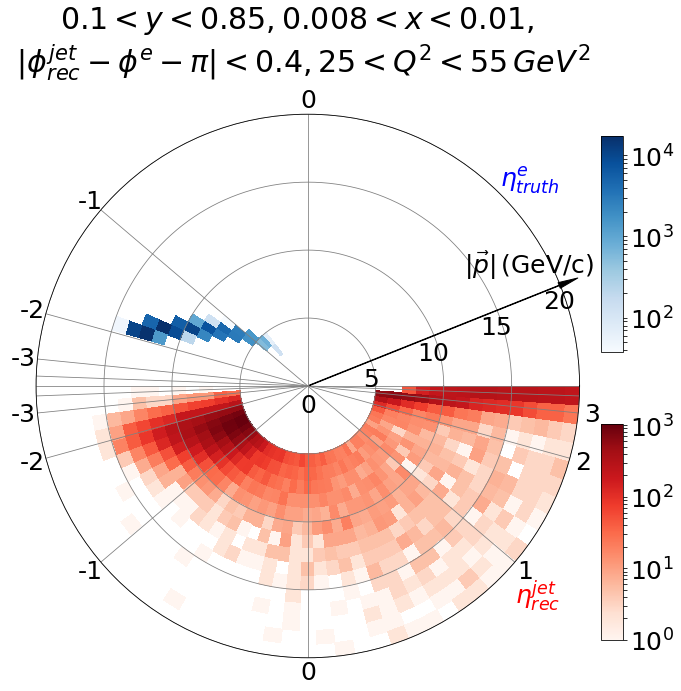

In [109]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['electron_truthTheta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj0_dphi['p'], aj0_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$0.1 < y < 0.85, 0.008 < x < 0.01$, \n $|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4, 25 < Q^2 < 55 \, GeV^2$',fontsize=30, y=1.03)
fig.savefig('images/polar0_dphi_Q2.pdf', bbox_inches='tight')

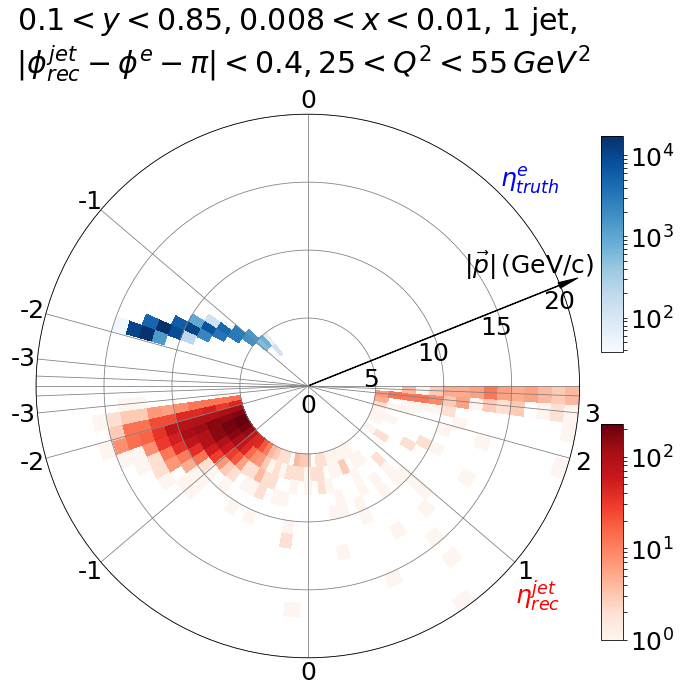

In [12]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['electron_truthTheta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj1_dphi['p'], aj1_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$0.1 < y < 0.85, 0.008 < x < 0.01$, 1 jet, \n $|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4, 25 < Q^2 < 55 \, GeV^2$',fontsize=30, y=1.03)
fig.savefig('images/polar1_dphi_Q2_njet_cut_first.pdf', bbox_inches='tight')

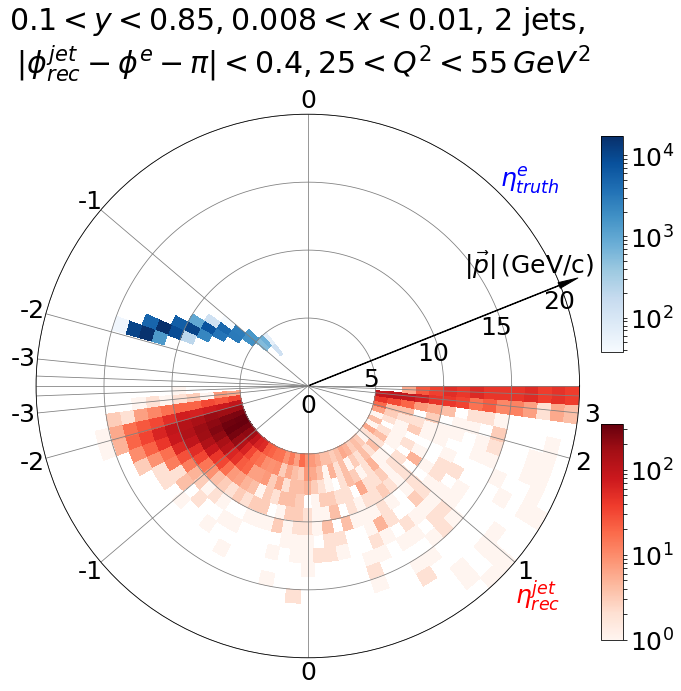

In [14]:
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_subplot(111, polar=True)

r_edges = np.linspace(0, nr, nr + 1)
theta_edges = np.linspace(0, 2*np.pi, ntheta + 1)
H_e = plt.hist2d(ae0['electron_truthP'], ae0['electron_truthTheta'], [r_edges, theta_edges])[0]
H_q = plt.hist2d(aj2_dphi['p'], aj2_dphi['theta_neg'], [r_edges, theta_edges])[0]
ax1.cla()

Theta, R = np.meshgrid(theta_edges, r_edges)
im_e = ax1.pcolormesh(Theta, R, H_e, cmap='Blues', norm=LogNorm())
im_q = ax1.pcolormesh(Theta, R, H_q, cmap='Reds', norm=LogNorm())
ax1.set_rgrids(radii, labels=r_labels, fontsize=25)
ax1.set_thetagrids(angles, labels=eta_labels, fontsize=25)
ax1.grid(color='grey')
cbar_e = fig.colorbar(im_e, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.55, 0.03, 0.3]))
cbar_e.ax.tick_params(labelsize=25)
cbar_q = fig.colorbar(im_q, shrink=0.7, pad=0.01, cax=plt.axes([0.92, 0.15, 0.03, 0.3]))
cbar_q.ax.tick_params(labelsize=25)
fig.text(0.78,0.78,'$\eta^{e}_{truth}$',fontsize=25, color='b')
fig.text(0.8,0.2,'$\eta^{jet}_{rec}$',fontsize=25, color='r')
ax1.annotate('', xy=(1,0.7), xycoords='axes fraction', xytext=(0.5,0.5), 
    arrowprops=dict(arrowstyle="Simple,tail_width=0.05,head_width=0.6,head_length=2", color='k'))
fig.text(0.73,0.66, r'$|\vec{p}| \, \mathrm{(GeV/c)}$',fontsize=25, color='k')
fig.suptitle('$0.1 < y < 0.85, 0.008 < x < 0.01$, 2 jets, \n $|\phi^{jet}_{rec} - \phi^e - \pi| < 0.4, 25 < Q^2 < 55 \, GeV^2$',fontsize=30, y=1.03)
fig.savefig('images/polar2_dphi_Q2_njet_cut_first.pdf', bbox_inches='tight')